#### Домашнее задание по лекции "Компьютерное зрение 1" DLL
-----------------------------------------------------------
  * Решить задачу детекции на основе SSD для датасета https://github.com/Shenggan/BCCD_Dataset1
  * Реализацию SSD можно подглядеть тут - https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

##### Преподаватель: Даниил Корбут, Алексей Миронов, Екатерина Апраксина, Юлия Пономарева


In [ ]:
# Скачивание необходимого
!wget -N https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/archive/master.zip
!unzip master.zip
!cp -Rnv /content/a-PyTorch-Tutorial-to-Object-Detection-master/* /content
!rm master.zip
!rm -R /content/a-PyTorch-Tutorial-to-Object-Detection-master
!wget -N https://github.com/Shenggan/BCCD_Dataset/archive/master.zip
!unzip master.zip
!rm master.zip

In [41]:
%matplotlib inline
import time
import torch

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset

import torchvision as tv

from  torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms.functional as FT
from torchvision.transforms import CenterCrop

import xml.etree.ElementTree as ET
import random

import json
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from model import SSD300, MultiBoxLoss


# from utils import *
# from detect import *
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import patches

# скрыть отображение предупреждений
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

from utils import *

## Presets

In [42]:
voc_labels = ('rbc', 'wbc', 'platelets')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}
data_folder = "C:/Users/k_tomilov/dl/CV/BCCD"
bccd_labels = ('background','rbc', 'wbc', 'platelets')

## Transforms (image augmentation)

In [43]:
def transform_(image, boxes, labels, split):
    """
    Apply the transformations above.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST', since different sets of transformations are applied
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """
    assert split in {'TRAIN', 'TEST'}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_boxes = boxes
    new_labels = labels
    # Skip the following operations for evaluation/testing
    if split == 'TRAIN':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
        if random.random() < 0.5:

            new_image, new_boxes = expand(new_image, boxes, filler=mean)

          # Randomly crop image (zoom in)
            new_image, new_boxes, new_labels = random_crop_(new_image, new_boxes, new_labels)

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_boxes, new_labels



In [44]:
def random_crop_(image, boxes, labels):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels

        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0),
                                           boxes)  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels

In [45]:
def photometric_distort(image):
    """
    Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.
    :param image: image, a PIL Image
    :return: distorted image
    """
    new_image = image

    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]

    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ == 'adjust_hue':
                # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:
                # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply this distortion
            new_image = d(new_image, adjust_factor)

    return new_image


In [46]:
def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [47]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

In [48]:
def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
    """
    Resize image. For the SSD300, resize to (300, 300).
    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes

In [49]:
def expand(image, boxes, filler):
    """
    Perform a zooming out operation by placing the image in a larger canvas of filler material.
    Helps to learn to detect smaller objects.
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param filler: RBG values of the filler material, a list like [R, G, B]
    :return: expanded image, updated bounding box coordinates
    """
    # Calculate dimensions of proposed expanded (zoomed-out) image
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    # Create such an image with the filler
    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)
    # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
    # because all expanded values will share the same memory, so changing one pixel will change all

    # Place the original image at random coordinates in this new image (origin at top-left of image)
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    # Adjust bounding boxes' coordinates accordingly
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(
        0)  # (n_objects, 4), n_objects is the no. of objects in this image

    return new_image, new_boxes

In [50]:
def flip(image, boxes):
    """
    Flip image horizontally.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

## BCCDDataset 

In [51]:
class BCCDDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder

        # Read data files
        im = []
        with open(os.path.join(data_folder + "/ImageSets/Main/" + split.lower() + '.txt'), 'r') as j:
          # чтение списка файлов для наборов train или test из /content/BCCD_Dataset-master/BCCD/ImageSets/Main
          for line in j:
            im.append(line.rstrip())
        self.images = im

    def __getitem__(self, i):
        # Read image
        image = Image.open(data_folder + '/JPEGImages/' + self.images[i] + '.jpg', mode='r')
        image = image.convert('RGB')
        id_ = self.images[i]

        anno = ET.parse(
            os.path.join(self.data_folder, 'Annotations', id_ + '.xml'))
        boxes = []
        labels = []
        
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')
            boxes.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('xmin','ymin', 'xmax', 'ymax')])
            name = obj.find('name').text.lower().strip()
            labels.append(bccd_labels.index(name))

        boxes = np.stack(boxes).astype(np.float32)
        boxes = torch.FloatTensor(boxes)
        labels = np.stack(labels).astype(np.int32)
        labels = torch.LongTensor(labels) 

        # Apply transformations
        image, boxes, labels = transform_(image, boxes, labels, split=self.split)

        return image, boxes, labels

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
       

        images = torch.stack(images, dim=0)


        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [52]:
train_dataset = BCCDDataset(data_folder, split='train')
test_dataset = BCCDDataset(data_folder, split='test')

In [53]:
len(train_dataset),len(test_dataset)

(205, 72)

## Data display

In [54]:
# изображение, боксы, классы
train_dataset[0] 

(tensor([[[1.4269, 1.3584, 1.3584,  ..., 1.5810, 1.5639, 1.5810],
          [1.4612, 1.3755, 1.3242,  ..., 1.6324, 1.5810, 1.5810],
          [1.4783, 1.3755, 1.3242,  ..., 1.6667, 1.5982, 1.5810],
          ...,
          [1.5639, 1.6667, 1.7694,  ..., 2.2489, 2.2318, 2.1462],
          [1.7352, 1.8208, 1.9235,  ..., 2.2489, 2.2318, 2.1462],
          [1.8893, 1.9578, 2.0092,  ..., 2.2489, 2.2489, 2.1804]],
 
         [[1.3256, 1.2031, 1.1155,  ..., 1.4482, 1.3256, 1.2731],
          [1.3431, 1.1856, 1.0805,  ..., 1.4482, 1.3431, 1.2731],
          [1.3081, 1.1506, 1.0455,  ..., 1.4832, 1.3606, 1.2556],
          ...,
          [1.7108, 1.8158, 1.9559,  ..., 2.2360, 2.3761, 2.3060],
          [1.9909, 2.1134, 2.2185,  ..., 2.2535, 2.3761, 2.2885],
          [2.2185, 2.3060, 2.3585,  ..., 2.3410, 2.4286, 2.3235]],
 
         [[0.6531, 0.7054, 0.9319,  ..., 1.4548, 1.4548, 1.4722],
          [0.7228, 0.7576, 0.9145,  ..., 1.4722, 1.4722, 1.4548],
          [0.8622, 0.8622, 0.9668,  ...,

In [55]:
# Функция отображает размеченное изображение для train_dataset[0] (1 канал цвета)
def show_real():    
    
    fig = plt.figure()
    TD = train_dataset[0]
  #add axes to the image
    ax = fig.add_axes([0,0,1,1])

  # read and plot the image
    
    image = TD[0][0]   
    %matplotlib inline
    image.show()

      # iterating over the image for different objects
    for i,row in enumerate(TD[1]) :

        xmin = row[0] *300
        xmax = row[2] * 300
        ymin = row[1] * 300
        ymax = row[3] * 300
        width = xmax - xmin
        height = ymax - ymin

        # assign different color to different classes of objects
        if TD[2][i].item() == 1:
            edgecolor = 'r'
            ax.annotate('RBC', xy=(xmax-40,ymin+20))
        elif TD[2][i].item() == 2:
            edgecolor = 'b'
            ax.annotate('WBC', xy=(xmax-40,ymin+20))
        elif TD[2][i].item() == 3:
            edgecolor = 'g'
            ax.annotate('Platelets', xy=(xmax-40,ymin+20))

            # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')

        ax.add_patch(rect)

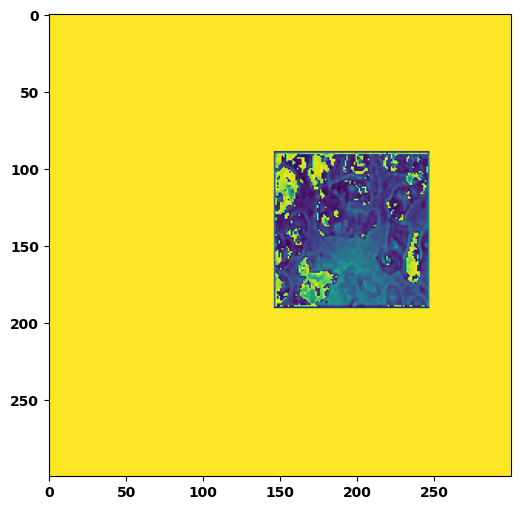

In [56]:
plt.figure(figsize = (6,6))
plt.imshow(tv.transforms.ToPILImage()(train_dataset[0][0][0]))


## Hyperparameters

In [57]:
# Data parameters
# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
epochs = 30
workers = 0  # number of workers for loading data in the DataLoader
print_freq = 6  # print training status every __ batches
lr = 2 * 1e-4  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True


## Train

In [58]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f}'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss = losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored

In [59]:
# Initialize model
if checkpoint is None:
    start_epoch = 0
    model = SSD300(n_classes=n_classes)
            # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Move to default device
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
train_dataset =BCCDDataset(data_folder,split='train')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations


    # Epochs
for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
    

        # One epoch's training
    train(train_loader=train_loader,model=model,criterion=criterion,optimizer=optimizer,epoch=epoch)

        # Save checkpoint
    save_checkpoint(epoch, model, optimizer)


Loaded base model.

Epoch: [0][0/26]	Batch Time 13.246 (13.246)	Data Time 1.250 (1.250)	Loss 16.4932
Epoch: [0][6/26]	Batch Time 12.708 (11.958)	Data Time 1.004 (0.955)	Loss 9.4877
Epoch: [0][12/26]	Batch Time 10.999 (11.636)	Data Time 0.868 (0.969)	Loss 7.3285
Epoch: [0][18/26]	Batch Time 13.895 (11.935)	Data Time 1.347 (0.995)	Loss 7.2045
Epoch: [0][24/26]	Batch Time 13.282 (12.309)	Data Time 1.178 (1.073)	Loss 6.8735
Epoch: [1][0/26]	Batch Time 11.745 (11.745)	Data Time 0.514 (0.514)	Loss 6.6612
Epoch: [1][6/26]	Batch Time 11.872 (11.866)	Data Time 0.432 (0.621)	Loss 6.5084
Epoch: [1][12/26]	Batch Time 11.930 (12.047)	Data Time 0.827 (0.700)	Loss 6.8513
Epoch: [1][18/26]	Batch Time 11.906 (11.947)	Data Time 0.565 (0.709)	Loss 6.3857
Epoch: [1][24/26]	Batch Time 12.012 (11.908)	Data Time 0.763 (0.705)	Loss 6.4396
Epoch: [2][0/26]	Batch Time 12.153 (12.153)	Data Time 0.588 (0.588)	Loss 6.1303
Epoch: [2][6/26]	Batch Time 12.037 (11.979)	Data Time 0.704 (0.636)	Loss 6.0091
Epoch: [2][1

## Detect

In [67]:
from torchvision import transforms # imports for detect stage needed
import torch.nn.functional as F

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


Loaded checkpoint from epoch 30.



In [62]:
def detect_objects_(model,predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = model.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], model.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                  
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

#                     # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
#                     # Find such boxes and update suppress indices
#                     suppress = torch.max(suppress, overlap[box] > max_overlap)                    
#                     # The max operation retains previously suppressed boxes, like an 'OR' operation                  
                    condition = overlap[box] > max_overlap
                    condition = torch.tensor(condition, dtype=torch.uint8).to(device)
                    #print(torch.tensor(condition,dtype=torch.uint8))
                    suppress = torch.max(suppress, condition)                    

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [77]:
def detect_(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = detect_objects_(model,predicted_locs, predicted_scores, min_score=min_score, max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()
    #font = ImageFont.load("arial.pil")
    #font = ImageFont.truetype("arial.ttf", 15)
    # font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',30)
    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        # text_size = font.getsize(det_labels[i].upper())
        text_size = font.getbbox(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

## Result

In [78]:
# список имен файлов с изображениями
all_files = os.listdir(data_folder + '/JPEGImages/')

test_files = []
with open(os.path.join(data_folder + '/ImageSets/Main/test.txt'), 'r') as j:
    for line in j:
        test_files.append(line.rstrip() + '.jpg')

In [79]:
test_files[random.randint(1, len(test_files))]

'BloodImage_00226.jpg'

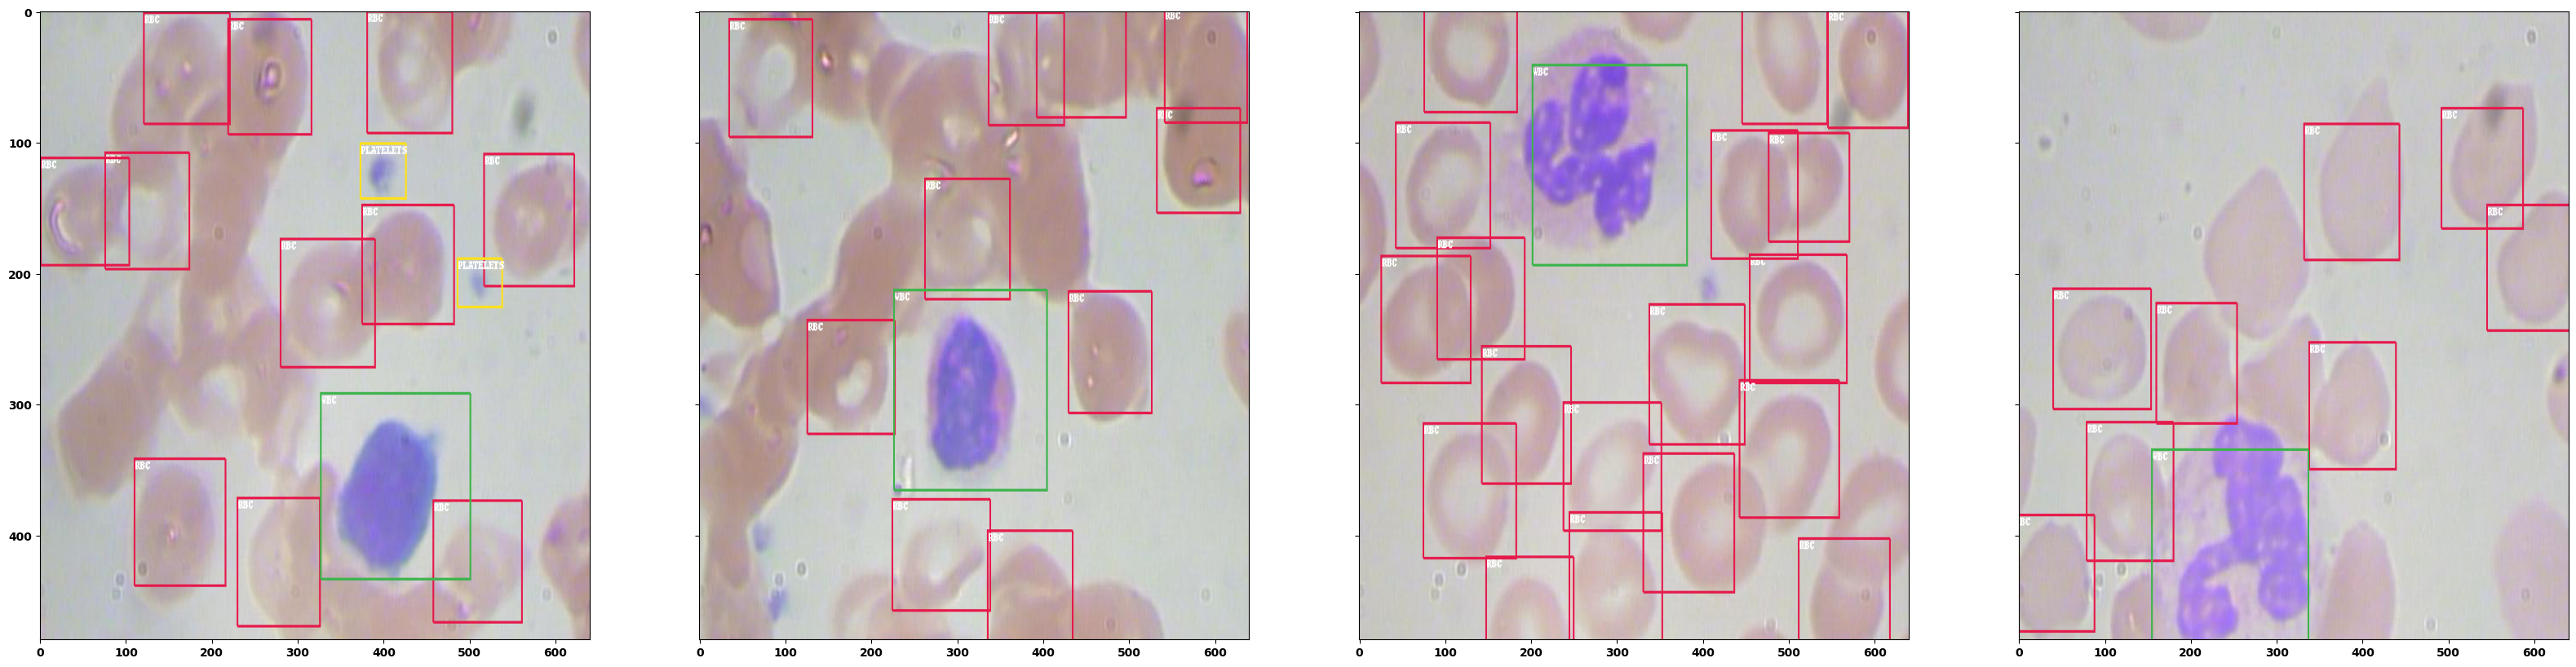

In [80]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(40,10))

files = test_files
for i in range(4):
    img_path = data_folder + '/JPEGImages/' + files[random.randint(1,len(files))]
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    ax[i].imshow(detect_(original_image, min_score=0.4, max_overlap=0.2, top_k=20), aspect="auto") #.show()
  

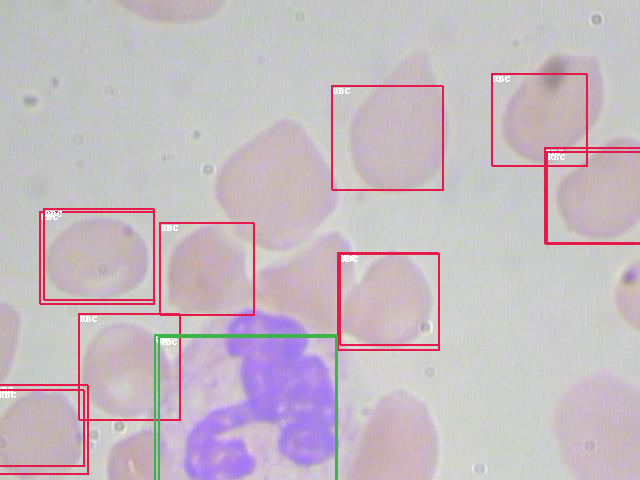

In [81]:
detect_(original_image, min_score=0.4, max_overlap=0.2, top_k=20)